In [128]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

warnings.simplefilter('ignore', ValueWarning)

from services.ProcessDataService import ProcessDataService


In [129]:
from services.SQLiteService import SQLiteService

database = SQLiteService()
database.connect()
data = database.select_data()

In [130]:
# Conversion en DataFrame
df = pd.DataFrame(data)

# Conversion de la colonne datetime en type datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M')

# Définition de l'index temporel
df = df.set_index('datetime').sort_index()

# Vérification des types
print(df.dtypes)

temperature    float64
dtype: object


In [ ]:
pds = ProcessDataService(df.copy())
pds.dataset.head()


,temperature
datetime,
2025-01-01 00:00:00,0.8
2025-01-01 01:00:00,2.1
2025-01-01 02:00:00,2.6
2025-01-01 03:00:00,3.1
2025-01-01 04:00:00,3.6


In [137]:
pds.view_stationarity()

AttributeError: 'ProcessDataService' object has no attribute 'view_stationarity'

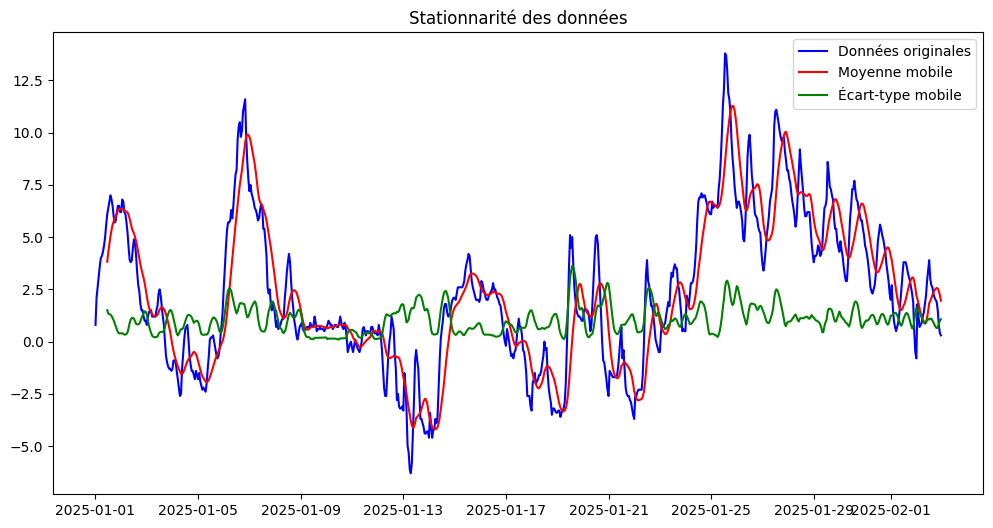

Statistique ADF : -2.5062721078256076
p-value : 0.11395570215767059
La série n'est pas stationnaire (p-value >= 0.05).


In [ ]:
# Calculer la moyenne mobile et l'écart-type mobile
rolling_mean = df['temperature'].rolling(window=12).mean()
rolling_std = df['temperature'].rolling(window=12).std()

# Tracer les données
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['temperature'], label='Données originales', color='blue')
plt.plot(rolling_mean, label='Moyenne mobile', color='red')
plt.plot(rolling_std, label='Écart-type mobile', color='green')
plt.legend(loc='best')
plt.title('Stationnarité des données')
plt.show()


adf_execute(df['temperature'])

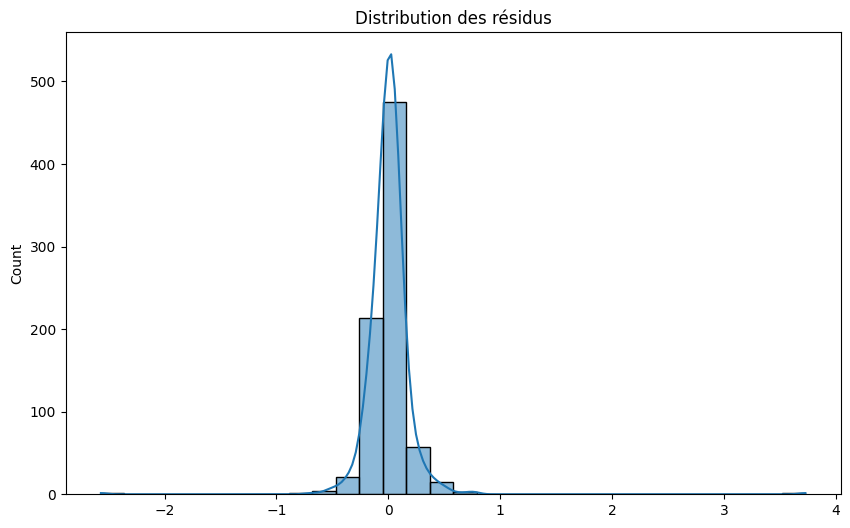

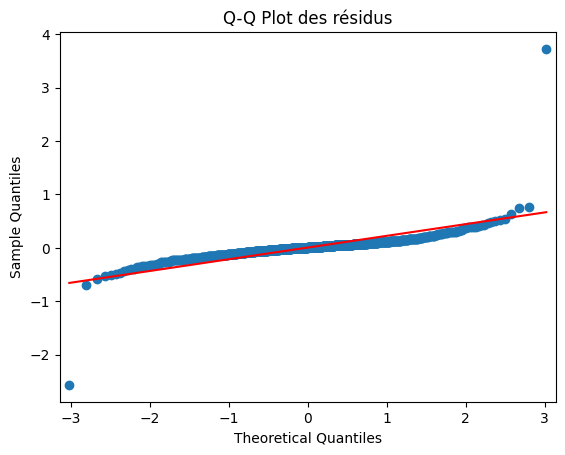

     lb_stat  lb_pvalue
24  68.17897   0.000004


In [ ]:
# Résidus du modèle
residuals = results.resid

# Histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution des résidus")
plt.show()

# Q-Q Plot pour vérifier la normalité
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot des résidus")
plt.show()

# Test de Ljung-Box pour vérifier l'autocorrélation
ljung_box_results = acorr_ljungbox(residuals, lags=[24], return_df=True)
print(ljung_box_results)


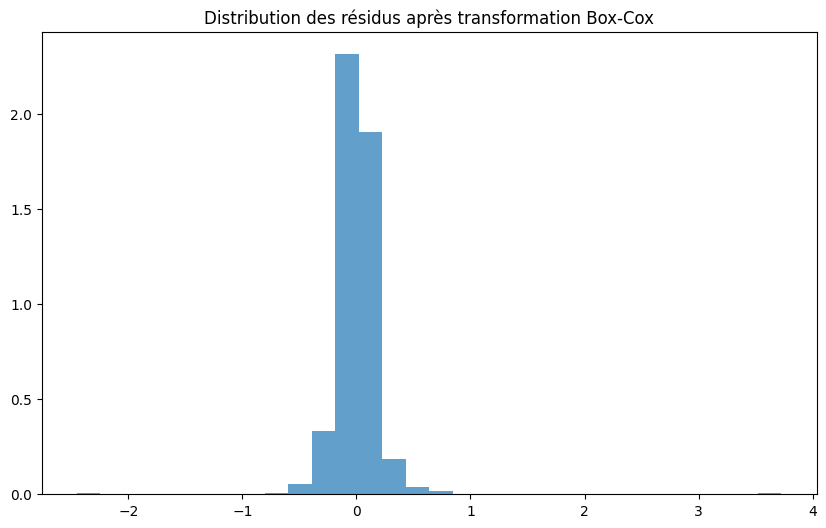

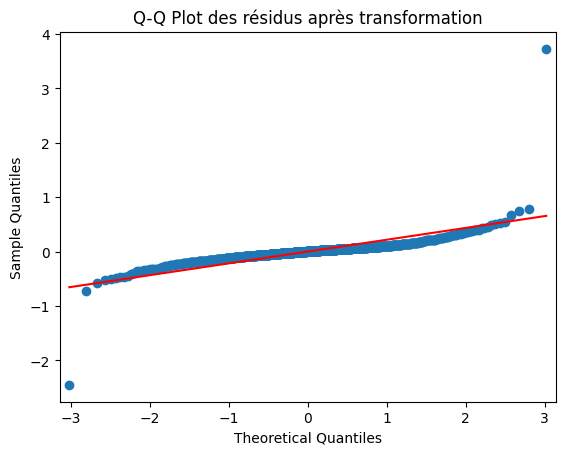

Paramètre lambda optimal: 0.5


In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import boxcox1p

# S'assurer que les données sont ≥ -1 (pour que x+1 soit ≥ 0)
min_temp = df['temperature'].min()
shift = abs(min_temp) + 0.1 if min_temp < -1 else 0
df['temperature_shifted'] = df['temperature'] + shift

# Appliquer boxcox1p avec un lambda trouvé empiriquement ou optimisé
lambda_param = 0.5  # exemple: tu pourrais essayer plusieurs valeurs
df['temperature_transformed'] = boxcox1p(df['temperature_shifted'], lambda_param)

# Réajuster le modèle avec les données transformées
model_transformed = sm.tsa.statespace.SARIMAX(
    df['temperature_transformed'],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_transformed = model_transformed.fit()

# Examiner les résidus après transformation
residuals_transformed = results_transformed.resid

# Visualiser les résidus transformés
plt.figure(figsize=(10, 6))
plt.hist(residuals_transformed, bins=30, alpha=0.7, density=True)
plt.title("Distribution des résidus après transformation Box-Cox")
plt.show()

# Q-Q plot après transformation
sm.qqplot(residuals_transformed, line='s')
plt.title("Q-Q Plot des résidus après transformation")
plt.show()

# Afficher le paramètre lambda optimal
print(f"Paramètre lambda optimal: {lambda_param}")


In [ ]:
print(results_transformed.summary())

                                     SARIMAX Results                                      
Dep. Variable:            temperature_transformed   No. Observations:                  792
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood                 348.811
Date:                            Fri, 11 Apr 2025   AIC                           -689.621
Time:                                    22:27:13   BIC                           -671.189
Sample:                                01-01-2025   HQIC                          -682.515
                                     - 02-02-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4924      0.055      9.015      0.000       0.385       0.599
ma.L1         -0.1389      0.059   

In [ ]:
df['jour_semaine'] = df.index.dayofweek  # 0=lundi, 6=dimanche
jour_dummies = pd.get_dummies(df['jour_semaine'], prefix='jour')
df = pd.concat([df, jour_dummies], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Fractionner les données en ensembles d'entraînement et de test
train, test = train_test_split(df['temperature'], test_size=0.2, shuffle=False)

# Vérifier les dimensions des ensembles
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (633,)
Test shape: (159,)


In [ ]:
# Exemple avec Prophet qui gère naturellement plusieurs niveaux de saisonnalité
from prophet import Prophet

# Préparer les données au format Prophet
prophet_df = df.reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df['y'] = df['temperature']  # Utiliser les données originales

# Créer et ajuster le modèle
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True
)
m.fit(prophet_df)

# Faire des prévisions
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)



ValueError: The indices for endog and exog are not aligned

In [ ]:
# Tester plusieurs combinaisons de paramètres sur les données transformées
import itertools

# Définir les plages de paramètres
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in itertools.product(range(0, 2), range(0, 2), range(0, 2))]

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                df['temperature_transformed'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print(f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}')
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                
        except Exception as e:
            continue
            
print(f'Meilleur modèle: SARIMAX{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}')


ARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:4547.101828249577
ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:3573.2135619248656
ARIMA(0, 0, 0)x(0, 1, 0, 24) - AIC:2243.916303323498
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:2159.5079271411814
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:2231.7276984474506
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:2218.3806009555724
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:2174.754056256428
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:2089.2235498880527
ARIMA(0, 0, 1)x(0, 0, 0, 24) - AIC:3494.310154228764
ARIMA(0, 0, 1)x(0, 0, 1, 24) - AIC:2585.6159544880074
ARIMA(0, 0, 1)x(0, 1, 0, 24) - AIC:1346.2742686399106
ARIMA(0, 0, 1)x(0, 1, 1, 24) - AIC:1279.7897178062008
ARIMA(0, 0, 1)x(1, 0, 0, 24) - AIC:1336.4425476110969
ARIMA(0, 0, 1)x(1, 0, 1, 24) - AIC:1313.043758449519
ARIMA(0, 0, 1)x(1, 1, 0, 24) - AIC:1305.7638126527702
ARIMA(0, 0, 1)x(1, 1, 1, 24) - AIC:1209.6168287740538
ARIMA(0, 1, 0)x(0, 0, 0, 24) - AIC:-328.58114269909606
ARIMA(0, 1, 0)x(0, 0, 1, 24) - AIC:-427.6114602214469
ARIMA(0, 1, 0)x(0, 1, 0, 24) - A

c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 0, 24) - AIC:-489.65836052715133
ARIMA(0, 1, 0)x(1, 0, 1, 24) - AIC:-595.9452015218721


c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 0, 24) - AIC:-384.308259675684
ARIMA(0, 1, 0)x(1, 1, 1, 24) - AIC:-571.2040966359863
ARIMA(0, 1, 1)x(0, 0, 0, 24) - AIC:-495.015689364881
ARIMA(0, 1, 1)x(0, 0, 1, 24) - AIC:-552.0690436869411
ARIMA(0, 1, 1)x(0, 1, 0, 24) - AIC:-350.59959720454816
ARIMA(0, 1, 1)x(0, 1, 1, 24) - AIC:-663.755175722272
ARIMA(0, 1, 1)x(1, 0, 0, 24) - AIC:-598.426820933975
ARIMA(0, 1, 1)x(1, 0, 1, 24) - AIC:-684.8705412988483
ARIMA(0, 1, 1)x(1, 1, 0, 24) - AIC:-475.5031985662554
ARIMA(0, 1, 1)x(1, 1, 1, 24) - AIC:-653.1652389068154
ARIMA(1, 0, 0)x(0, 0, 0, 24) - AIC:-323.5005279458039


c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 24) - AIC:-427.6538641013266
ARIMA(1, 0, 0)x(0, 1, 0, 24) - AIC:-271.7680890960745
ARIMA(1, 0, 0)x(0, 1, 1, 24) - AIC:-584.6940272259538
ARIMA(1, 0, 0)x(1, 0, 0, 24) - AIC:-489.7354379040045
ARIMA(1, 0, 0)x(1, 0, 1, 24) - AIC:-597.1685398179153
ARIMA(1, 0, 0)x(1, 1, 0, 24) - AIC:-388.1008109383601
ARIMA(1, 0, 0)x(1, 1, 1, 24) - AIC:-575.7328475998372
ARIMA(1, 0, 1)x(0, 0, 0, 24) - AIC:-494.56331827619096


c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 24) - AIC:-553.1559804379679
ARIMA(1, 0, 1)x(0, 1, 0, 24) - AIC:-361.3849176468884
ARIMA(1, 0, 1)x(0, 1, 1, 24) - AIC:-668.8208432758513
ARIMA(1, 0, 1)x(1, 0, 0, 24) - AIC:-598.6809987878192
ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:-688.7410764817125


c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 0, 24) - AIC:-481.89567511929204
ARIMA(1, 0, 1)x(1, 1, 1, 24) - AIC:-659.3772669717048
ARIMA(1, 1, 0)x(0, 0, 0, 24) - AIC:-560.2190701103976
ARIMA(1, 1, 0)x(0, 0, 1, 24) - AIC:-597.7005316037053
ARIMA(1, 1, 0)x(0, 1, 0, 24) - AIC:-375.37171983468227
ARIMA(1, 1, 0)x(0, 1, 1, 24) - AIC:-690.2868968465851
ARIMA(1, 1, 0)x(1, 0, 0, 24) - AIC:-632.2794066420756
ARIMA(1, 1, 0)x(1, 0, 1, 24) - AIC:-713.3844286447113
ARIMA(1, 1, 0)x(1, 1, 0, 24) - AIC:-500.1833554256216
ARIMA(1, 1, 0)x(1, 1, 1, 24) - AIC:-678.4520123607356
ARIMA(1, 1, 1)x(0, 0, 0, 24) - AIC:-558.2840150686743
ARIMA(1, 1, 1)x(0, 0, 1, 24) - AIC:-596.2126407840312
ARIMA(1, 1, 1)x(0, 1, 0, 24) - AIC:-375.81769961487976
ARIMA(1, 1, 1)x(0, 1, 1, 24) - AIC:-689.6213371840165
ARIMA(1, 1, 1)x(1, 0, 0, 24) - AIC:-633.0556780448961
ARIMA(1, 1, 1)x(1, 0, 1, 24) - AIC:-713.4436683853692
ARIMA(1, 1, 1)x(1, 1, 0, 24) - AIC:-500.37684284104705
ARIMA(1, 1, 1)x(1, 1, 1, 24) - AIC:-678.3794689231651
Meilleur modèle: SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
# Ensure the required module is installed

# Ordre non-saisonnier (p,d,q) et saisonnier (P,D,Q,s)
# s=24 pour des données horaires avec cycle quotidien
# Définir les plages de paramètres pour le grid search
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [24]  # Période saisonnière pour des données horaires

# Créer toutes les combinaisons possibles de paramètres
parametres = list(product(p, d, q))
parametres_saisonniers = list(product(P, D, Q, s))

# Initialiser les meilleures valeurs
meilleur_aic = float("inf")
meilleur_parametre = None
meilleur_parametre_saisonnier = None

# Grid search
for param in parametres:
    for param_saisonnier in parametres_saisonniers:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_saisonnier,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < meilleur_aic:
                meilleur_aic = results.aic
                meilleur_parametre = param
                meilleur_parametre_saisonnier = param_saisonnier
        except Exception as e:
            continue

print(f"Meilleur AIC: {meilleur_aic}")
print(f"Meilleur paramètre: {meilleur_parametre}")
print(f"Meilleur paramètre saisonnier: {meilleur_parametre_saisonnier}")

# Utiliser les meilleurs paramètres pour ajuster le modèle final
model = SARIMAX(train,
                order=meilleur_parametre,
                seasonal_order=meilleur_parametre_saisonnier,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

# Prédictions
pred = results.get_forecast(steps=96)  # Prédire 48h
pred_ci = pred.conf_int()

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, 
         color='red', label='Prévisions')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Comparaison entre Train, Test et Prévisions')
plt.show()


c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Laurent\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Meilleur AIC: 642.6803607594225
Meilleur paramètre: (1, 1, 1)
Meilleur paramètre saisonnier: (0, 1, 1, 24)


KeyboardInterrupt: 